In [5]:
import srfloat as sr
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import csv

matplotlib.rcParams['text.usetex'] = True

# set the random seeds for srfloat and numpy to get reproducible results
sr.seed(42)
np.random.seed(42)

# list of r values to test 
rand_bits = [3, 6, 7, 8, 10] 
r_len = len(rand_bits)

In [6]:
# RN and SR operators with parameterizable r value
cast_binary16_sr = lambda x, r : sr.cast_sr(float(x), 10, 5, r, True, False)
cast_binary16_rn = lambda x : sr.cast_rn(x, 10, 5, True, False)

vectorized_cast_binary16_rn = np.vectorize(cast_binary16_rn)


def rosenbrock(x, y):
    z = (1 - x)**2 + 100 * (y - x**2)**2
    return z

def rosenbrock_gradient(x, y):
    dx = -2 * (1 - x) - 400 * x * (y - x**2)
    dy = 200 * (y - x**2)
    return np.array([dx, dy])

def gradient_descent(start_point, learning_rate, num_iterations):
    path = [start_point]
    point = np.array(start_point)

    for _ in range(num_iterations):
        gradient = rosenbrock_gradient(point[0], point[1])
        point = point - learning_rate * gradient
        
        # Clip the point to stay within [0,1]^2
        point = np.clip(point, 0, 1)
        
        path.append(point.copy())

    return np.array(path)

def rosenbrock_cast(x, y, cast_function):
    z_0 = cast_function(1 - x)
    z_1 = cast_function(z_0**2)
    z_00 = cast_function(x**2)
    z_2 = cast_function(y - z_00)
    z_3 = cast_function(z_2**2)
    z_4 = cast_function(100 * z_3)
    z = cast_function(z_1 + z_4)
    return z

def rosenbrock_gradient_cast(x, y, cast_function):
    z_1 = cast_function(x - 1)
    z_2 = cast_function(2 * z_1)
    z_0 = cast_function(x**2)
    z_3 = cast_function(y - z_0)
    z_00 = cast_function(x * z_3)
    z_4 = cast_function(400 * z_00)
    dx = cast_function(z_2 - z_4)
    dy = cast_function(200 * z_3)
    return np.array([dx, dy])

def gradient_descent_cast(start_point, learning_rate, num_iterations, cast_function):
    path = [start_point]
    point = np.array(start_point)

    for _ in range(num_iterations):
        gradient = rosenbrock_gradient_cast(point[0], point[1], cast_function)
        tmp = cast_function(learning_rate * gradient[0])
        
        point[0] = cast_function( point[0] - tmp )
        tmpp = cast_function(learning_rate * gradient[1])
        point[1] = cast_function( point[1] - tmpp)

        
        # Clip the point to stay within [0,1]^2
        point = np.clip(point, 0, 1)
        
        path.append(point.copy())

    return np.array(path)

In [7]:
def run_gd(start_point, learning_rate, runs, root_filename):
    num_iterations = [n for n in range(10, 5000, 100)]
    rn_min = []
    rn16_min = []
    sr16_min = [[] for _ in range(r_len)]

    for k in num_iterations:
        # Run gradient descent
        path = gradient_descent(start_point, learning_rate, k)
        path_rn = gradient_descent_cast(start_point, learning_rate, k, vectorized_cast_binary16_rn)
        rn_min.append(rosenbrock(path[-1][0], path[-1][1]))
        rn16_min.append(rosenbrock_cast(path_rn[-1][0], path_rn[-1][1], vectorized_cast_binary16_rn))

    
        for r in range(r_len):
            vectorized_cast_binary16_sr = np.vectorize(lambda x: cast_binary16_sr(x, rand_bits[r]))
            sr_vec = []
            for i in range(runs):
                result = gradient_descent_cast(start_point, learning_rate, k, vectorized_cast_binary16_sr)
                sr_vec.append(rosenbrock_cast(result[-1][0], result[-1][1], vectorized_cast_binary16_sr))
            sr16_min[r].append(np.mean(sr_vec)) 


    # Save binary16 RN log to CSV
    filename = root_filename + 'binary16_rn.csv'
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['min_binary-16'])  
        for err in rn16_min:
            writer.writerow([str(err)])  

    # Save binary64 RN log to CSV
    filename = root_filename + 'binary64_rn.csv'
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['min_binary-64'])  
        for err in rn_min:
            writer.writerow([str(err)])         

    # Save sr_min to CSV
    for r in range(len(rand_bits)):
        filename = root_filename + f'binary16_sr{rand_bits[r]}.csv'
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            header = [f'sr_min-{rand_bits[r]}']  # Header with rand_bits[r]
            writer.writerow(header)
            for err in sr16_min[r]:
                writer.writerow([str(err)])          

    # RN plots
    plt.plot(num_iterations, rn_min, '--',  label='Binary-64')
    plt.plot(num_iterations, rn16_min, '--', label='Binary-16')

    # SR plots
    for r in range(r_len):
        plt.plot(num_iterations, sr16_min[r], '--', label=f'sr_{rand_bits[r]}')

    plt.yscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Forward error wrt to minimum')
    plt.title('GD on the Rosenbrock Function')
    plt.legend()

    plt.show()

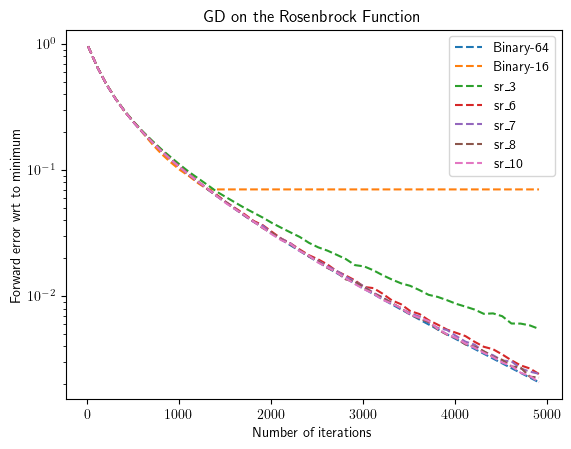

In [8]:
# examine convergence of GD with starting point [0, 0]
run_gd(start_point=[0.0, 0.0], learning_rate=1e-3, runs=10, root_filename='exp1')

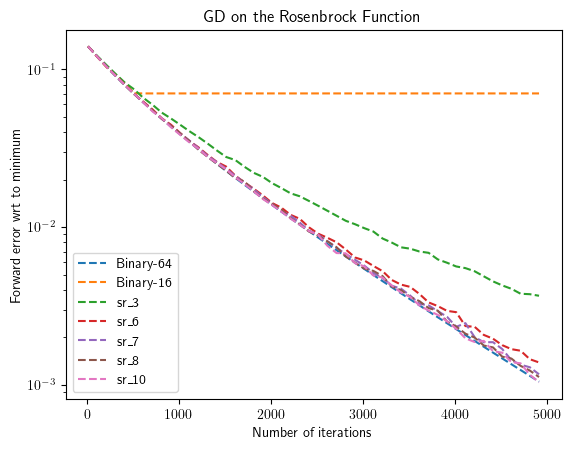

In [9]:
# examine convergence of GD with starting point [0.5, 0.5]
run_gd(start_point=[0.5, 0.5], learning_rate=1e-3, runs=10, root_filename='exp2')